In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN,SVMSMOTE

In [ ]:
import numpy as np
from numpy import random as rand
from sklearn.linear_model import LogisticRegression
# DO NOT CHANGE THE NAME OF THIS METHOD OR ITS INPUT OUTPUT BEHAVIOR

# PLEASE BE CAREFUL THAT ERROR CLASS NUMBERS START FROM 1 AND NOT 0. THUS, THE FIFTY ERROR CLASSES ARE
# NUMBERED AS 1 2 ... 50 AND NOT THE USUAL 0 1 ... 49. PLEASE ALSO NOTE THAT ERROR CLASSES 33, 36, 38
# NEVER APPEAR IN THE TRAINING SET NOR WILL THEY EVER APPEAR IN THE SECRET TEST SET (THEY ARE TOO RARE)

# Input Convention
# X: n x d matrix in csr_matrix format containing d-dim (sparse) bag-of-words features for n test data points
# k: the number of compiler error class guesses to be returned for each test data point in ranked order


# Output Convention
# The method must return an n x k numpy nd-array (not numpy matrix or scipy matrix) of classes with the i-th row
# containing k error classes which it thinks are most likely to be the correct error class for the i-th test point.
# Class numbers must be returned in ranked order i.e. the label yPred[i][0] must be the best guess for the error class
# for the i-th data point followed by yPred[i][1] and so on.

# CAUTION: Make sure that you return (yPred below) an n x k numpy nd-array and not a numpy/scipy/sparse matrix
# Thus, the returned matrix will always be a dense matrix. The evaluation code may misbehave and give unexpected
# results if an nd-array is not returned. Please be careful that classes are numbered from 1 to 50 and not 0 to 49.

def findErrorClass( X, k ):
	# Find out how many data points we have
	n = X.shape[0]
	# Load and unpack a dummy model to see an example of how to make predictions
	# The dummy model simply stores the error classes in decreasing order of their popularity
	npzModel = np.load( "model.npz" )
	model = npzModel[npzModel.files[0]]
	# Let us predict a random subset of the 2k most popular labe
	# ls no matter what the test point
	shortList = model[0:2*k]
	# Make sure we are returning a numpy nd-array and not a numpy matrix or a scipy sparse matrix
	yPred = np.zeros( (n, k) )
	for i in range( n ):
		yPred[i,:] = rand.permutation( shortList )[0:k]

	return yPred

In [ ]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import dump_svmlight_file
from scipy import sparse as sps

In [ ]:

def loadData( filename, dictSize = 225 ):
	X, y = load_svmlight_file( filename, multilabel = False, n_features = dictSize, offset = 1 )
	return (X, y)

def dumpData( X, y, filename ):
	(n, d) = X.shape
	assert len(y) == n, "Mismatch in number of feature vectors and number of label vectors"
	dump_svmlight_file( X, y, filename, multilabel = False, zero_based = True, comment = "%d, %d" % (n, d) )

# Not the best way to do things in Python but I could not find a neater workaround
# Let me know if you know one that avoids a messy loop
def removeDuplicates( pred, imputation ):
	# Create a new array so that the original input array pred is unaffected
	deDup = np.ones( pred.shape ) * imputation
	for i in range( pred.shape[0] ):
		# Retain only the first occurrence of a label in every row
		(u, idx) = np.unique( pred[i,:], return_index = True )
		deDup[i,idx] = u
	return deDup

# Validate that data is nice and well behaved
# Return a copy of the predicted error classes that removes duplicates
# The original data is not affected i.e. this method can be called repeatedly
# Also return a one-hot representation of the gold labels for easier processing
# without affecting the arguments sent as inputs
def validateAndCleanup( yGold, yPred, k ):
	n = len(yGold)

	# Make sure the prediction matrix is in correct shape
	assert yPred.shape[0] == n, "Mismatch in number of test data points and number of predictions"
	assert yPred.shape[1] == k, "Mismatch in number of predictions received and number expected"

	# Penalize duplicates in yPred by replacing them with predictions of the dummy error class 0
	# Since error classes are numbered from 1 to 50, the 0 error class is a safe dummy choice
	yPredNew = removeDuplicates( yPred, 0 )

	# Need to convert the gold labels into a one-hot representation to make things easier later on
	yGoldNew = np.zeros( (n, 50) )
	# The -1 step is required since gold labels are indexed 1 ... 50 whereas Python expects zero_based indices
	yGoldNew[ np.arange(n), yGold[:,np.newaxis].astype(int).T - 1 ] = 1

	return (yGoldNew, yPredNew)

# For a given value of k, return prec@1, prec@2, ..., prec@k
def getPrecAtK( yGold, yPred, k ):
	n = len(yGold)
	(yGoldNew, yPredNew) = validateAndCleanup( yGold, yPred, k )

	# Use some fancy indexing (yes, this is the formal term for the technique)
	# to find out where all did we predict the correct error class
	# Python indexing with arrays creates copies of data so we are safe
	# The -1 step is required since predicted labels are indexed 1 ... 50 whereas Python expects zero_based indices
	wins = yGoldNew[ np.arange( n )[:,np.newaxis], yPredNew.astype(int) - 1 ]

	# Find how many times did we correctly predict the correct class at the blah-th position
	totWins = np.sum( wins, axis = 0 )
	# Find how many times did we correctly predict the correct class at any one of the top blah positions
	cumWins = np.cumsum( totWins )

	# Normalize and return
	precAtK = cumWins / n
	return precAtK

# For a given value of k, return mprec@1, mprec@2, ..., mprec@k
def getMPrecAtK( yGold, yPred, k ):
	C = 50 # There are 50 error classes
	CEff = 0 # Number of classes that actually have a presence in the test data
	(yGoldNew, yPredNew) = validateAndCleanup( yGold, yPred, k )
	mPrecAtK = np.zeros( k )

	# For all real error classes (exclude the dummy error class)
	for cls in range( C ):
		# Find data points for which this is the error class
		pointsWithThisErrorClass = (yGoldNew[:, cls] == 1).reshape( -1 )
		n_cls = np.sum( yGoldNew[:, cls] )

		# If there exist data points for which this is the correct error class
		if n_cls > 0:
			# Find all data points for which this class was predicted
			# Create a new array so that the array yPredNew is unaffected since it has to be reused
			# The +1 is required since the counter cls runs from 0 to 49 whereas the predictions are from 1 to 50
			winsThisClass = np.zeros( yPredNew.shape )
			winsThisClass[ yPredNew == cls + 1 ] = 1
			# Remove cases of data points for which this is not the correct error class
			winsThisClass[ ~pointsWithThisErrorClass, : ] = 0
			# How many times did we correctly predict this error class at the blah-th position?
			totWinsThisClass = np.sum( winsThisClass, axis = 0 )
			# Find how many times did we correctly predict this error class at any one of the top blah positions
			cumWins = np.cumsum( totWinsThisClass )
			# Add the wins to mprec@blah
			mPrecAtK += cumWins / n_cls
			CEff += 1
	return mPrecAtK / CEff


In [ ]:
import time as tm

# This file is intended to demonstrate how we would evaluate your codeP
# The data loader needs to know how many feature dimensions are there
dictSize = 225
(X, y) = loadData( "train", dictSize = dictSize )

# Get error class predictions from predict.py and time the thing
tic = tm.perf_counter()
yPred = findErrorClass( X, 5 )
toc = tm.perf_counter()

print( "Total time taken is %.6f seconds " % (toc - tic) )

preck = getPrecAtK( y, yPred, 5 )
# The macro precision code takes a bit longer to execute due to the for loop over labels
mpreck = getMPrecAtK( y, yPred, 5 )

# According to our definitions, both prec@k and mprec@k should go up as k goes up i.e. for your
# method, prec@i > prec@j if i > j and mprec@i > mprec@j if i > j. See the assignment description
# to convince yourself why this must be the case.

print( "prec@1: %0.3f" % preck[0], "prec@3: %0.3f" % preck[2], "prec@5: %0.3f" % preck[4] )
# Dont be surprised if mprec is small -- it is hard to do well on rare error classes
print( "mprec@1: %0.3e" % mpreck[0], "mprec@3: %0.3e" % mpreck[2], "mprec@5: %0.3e" % mpreck[4] )

Total time taken is 0.042576 seconds 
prec@1: 0.086 prec@3: 0.256 prec@5: 0.426
mprec@1: 2.047e-02 mprec@3: 6.412e-02 mprec@5: 1.070e-01


In [ ]:
X,y = loadData("train",225)
print(X.shape,y.shape)

(10000, 225) (10000,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,stratify=y)
print(X_train.shape,X_test.shape)
X, y = SMOTE(k_neighbors = 1).fit_resample(X_train, y_train)
print(X.shape,y.shape)

(7500, 225) (2500, 225)
(90193, 225) (90193,)


In [ ]:
LogReg = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
y_pred = LogReg.predict(X_train)
print(y_pred.shape)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc = accuracy_score(y_train, y_pred)
acc

In [ ]:
y_pred_test = LogReg.predict(X_test)
acc2 = accuracy_score(y_test,y_pred_test)
print(acc2)

In [ ]:
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [ ]:
count = {}
for i in y:
  if i in count:
    count[i] += 1
  else:
    count[i] = 1
print(count)
count_fin = sorted(count.items(), key=lambda kv:(kv[1], kv[0]))[::-1]

{1.0: 1919, 4.0: 1919, 3.0: 1919, 37.0: 1919, 5.0: 1919, 24.0: 1919, 2.0: 1919, 32.0: 1919, 9.0: 1919, 21.0: 1919, 7.0: 1919, 10.0: 1919, 8.0: 1919, 12.0: 1919, 29.0: 1919, 45.0: 1919, 35.0: 1919, 19.0: 1919, 48.0: 1919, 17.0: 1919, 13.0: 1919, 31.0: 1919, 30.0: 1919, 23.0: 1919, 20.0: 1919, 43.0: 1919, 15.0: 1919, 39.0: 1919, 11.0: 1919, 22.0: 1919, 18.0: 1919, 28.0: 1919, 16.0: 1919, 25.0: 1919, 50.0: 1919, 6.0: 1919, 26.0: 1919, 42.0: 1919, 47.0: 1919, 41.0: 1919, 40.0: 1919, 34.0: 1919, 49.0: 1919, 44.0: 1919, 46.0: 1919, 14.0: 1919, 27.0: 1919}


In [ ]:
test_dic = dict(sorted(count.items(), key=lambda item: item[1], reverse=True))
print(test_dic)

{1.0: 1919, 4.0: 1919, 3.0: 1919, 37.0: 1919, 5.0: 1919, 24.0: 1919, 2.0: 1919, 32.0: 1919, 9.0: 1919, 21.0: 1919, 7.0: 1919, 10.0: 1919, 8.0: 1919, 12.0: 1919, 29.0: 1919, 45.0: 1919, 35.0: 1919, 19.0: 1919, 48.0: 1919, 17.0: 1919, 13.0: 1919, 31.0: 1919, 30.0: 1919, 23.0: 1919, 20.0: 1919, 43.0: 1919, 15.0: 1919, 39.0: 1919, 11.0: 1919, 22.0: 1919, 18.0: 1919, 28.0: 1919, 16.0: 1919, 25.0: 1919, 50.0: 1919, 6.0: 1919, 26.0: 1919, 42.0: 1919, 47.0: 1919, 41.0: 1919, 40.0: 1919, 34.0: 1919, 49.0: 1919, 44.0: 1919, 46.0: 1919, 14.0: 1919, 27.0: 1919}


In [ ]:
wts = {}
tot_samples = 10000
j = 0
for i in range(50):
  if i == 32 or i == 35 or i == 37:
    #weights[float(i+1)] = 1
    pass
  else:
    wts[float(j+1)] = tot_samples/(50*(count[float(j+1)]))
  j += 1
print(wts)

{1.0: 0.10422094841063054, 2.0: 0.10422094841063054, 3.0: 0.10422094841063054, 4.0: 0.10422094841063054, 5.0: 0.10422094841063054, 6.0: 0.10422094841063054, 7.0: 0.10422094841063054, 8.0: 0.10422094841063054, 9.0: 0.10422094841063054, 10.0: 0.10422094841063054, 11.0: 0.10422094841063054, 12.0: 0.10422094841063054, 13.0: 0.10422094841063054, 14.0: 0.10422094841063054, 15.0: 0.10422094841063054, 16.0: 0.10422094841063054, 17.0: 0.10422094841063054, 18.0: 0.10422094841063054, 19.0: 0.10422094841063054, 20.0: 0.10422094841063054, 21.0: 0.10422094841063054, 22.0: 0.10422094841063054, 23.0: 0.10422094841063054, 24.0: 0.10422094841063054, 25.0: 0.10422094841063054, 26.0: 0.10422094841063054, 27.0: 0.10422094841063054, 28.0: 0.10422094841063054, 29.0: 0.10422094841063054, 30.0: 0.10422094841063054, 31.0: 0.10422094841063054, 32.0: 0.10422094841063054, 34.0: 0.10422094841063054, 35.0: 0.10422094841063054, 37.0: 0.10422094841063054, 39.0: 0.10422094841063054, 40.0: 0.10422094841063054, 41.0: 0.1

In [ ]:
weights = {}
maxx = test_dic[2.0]
j = 0
for i in range(50):
  if i == 32 or i == 35 or i == 37:
    #weights[float(i+1)] = 1
    pass
  else:
    weights[float(j+1)] = maxx/test_dic[float(i+1)]
  j += 1
print(weights)

{1.0: 1.0, 2.0: 1.0, 3.0: 1.0, 4.0: 1.0, 5.0: 1.0, 6.0: 1.0, 7.0: 1.0, 8.0: 1.0, 9.0: 1.0, 10.0: 1.0, 11.0: 1.0, 12.0: 1.0, 13.0: 1.0, 14.0: 1.0, 15.0: 1.0, 16.0: 1.0, 17.0: 1.0, 18.0: 1.0, 19.0: 1.0, 20.0: 1.0, 21.0: 1.0, 22.0: 1.0, 23.0: 1.0, 24.0: 1.0, 25.0: 1.0, 26.0: 1.0, 27.0: 1.0, 28.0: 1.0, 29.0: 1.0, 30.0: 1.0, 31.0: 1.0, 32.0: 1.0, 34.0: 1.0, 35.0: 1.0, 37.0: 1.0, 39.0: 1.0, 40.0: 1.0, 41.0: 1.0, 42.0: 1.0, 43.0: 1.0, 44.0: 1.0, 45.0: 1.0, 46.0: 1.0, 47.0: 1.0, 48.0: 1.0, 49.0: 1.0, 50.0: 1.0}


In [ ]:
sorted_weights = dict(sorted(weights.items(), key=lambda item: item[1], reverse=True))
print(sorted_weights)

{1.0: 1.0, 2.0: 1.0, 3.0: 1.0, 4.0: 1.0, 5.0: 1.0, 6.0: 1.0, 7.0: 1.0, 8.0: 1.0, 9.0: 1.0, 10.0: 1.0, 11.0: 1.0, 12.0: 1.0, 13.0: 1.0, 14.0: 1.0, 15.0: 1.0, 16.0: 1.0, 17.0: 1.0, 18.0: 1.0, 19.0: 1.0, 20.0: 1.0, 21.0: 1.0, 22.0: 1.0, 23.0: 1.0, 24.0: 1.0, 25.0: 1.0, 26.0: 1.0, 27.0: 1.0, 28.0: 1.0, 29.0: 1.0, 30.0: 1.0, 31.0: 1.0, 32.0: 1.0, 34.0: 1.0, 35.0: 1.0, 37.0: 1.0, 39.0: 1.0, 40.0: 1.0, 41.0: 1.0, 42.0: 1.0, 43.0: 1.0, 44.0: 1.0, 45.0: 1.0, 46.0: 1.0, 47.0: 1.0, 48.0: 1.0, 49.0: 1.0, 50.0: 1.0}


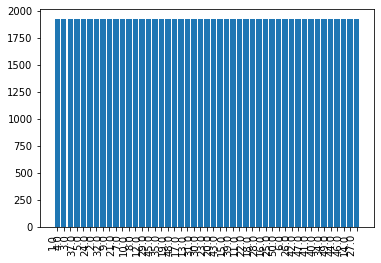

In [ ]:
ax = plt.subplot()
plt.bar(range(len(count)), list(count.values()), align='center')
plt.xticks(range(len(count)), list(count.keys()))
plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

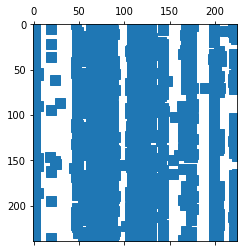

In [ ]:
plt.spy(X_train[510:750,:])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
"""model = LogisticRegression(random_state=0,max_iter=100)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

'model = LogisticRegression(random_state=0,max_iter=100)\nsolvers = [\'newton-cg\', \'lbfgs\', \'liblinear\']\npenalty = [\'l2\']\nc_values = [100, 10, 1.0, 0.1, 0.01]\ngrid = dict(solver=solvers,penalty=penalty,C=c_values)\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=\'accuracy\',error_score=0)\ngrid_result = grid_search.fit(X_train, y_train)\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))'

In [ ]:
model = LogisticRegression(max_iter=1000,multi_class = 'ovr',C=10)
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
acc3 = accuracy_score(y_train,y_pred)
print(acc3)

NameError: ignored

In [ ]:
y_pred_test = model.predict(X_test)
acc3 = accuracy_score(y_test,y_pred_test)
print(acc3)

In [ ]:
model = LogisticRegression(max_iter=5000,multi_class = 'ovr',C=10,class_weight='balanced')
print(X_train.shape,y_train.shape)
model.fit(X_train,y_train)
y_pred = model.predict_proba(X_train)
print(y_pred.shape)
#y_pred = y_pred[:,:5]
#print(y_pred.shape)

(7500, 225) (7500,)
(7500, 47)


In [ ]:
dic = {0:12,1:13,2:50,3:5,4:56,5:25,6:99,7:1,8:16}
dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
for i in dic:
  print(i,dic[i])

6 99
4 56
2 50
5 25
8 16
1 13
0 12
3 5
7 1


In [ ]:
def topFive(dic):
  res = []
  dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
  c = 5
  for i in dic:
    if c == 0:
      break
    res.append(i)
    c -= 1
  return np.array(res)

In [ ]:
y_pred_fin = []
for y in y_pred:
  j = 0
  y_pred_tmp = []
  for i in range(50):
    if i == 32 or i == 35 or i ==  37:
      y_pred_tmp.append(0)
    else:
      y_pred_tmp.append(y[j])
      j += 1
  y_pred_fin.append(y_pred_tmp)
y_pred_fin = np.array(y_pred_fin)
print(y_pred_fin.shape)

(7500, 50)


In [ ]:
"""
y_dic = {}
for i in range(len(y_pred)):
  y_dic[i+1] = y_pred[i]
print(y_dic)
"""
##
res = []
for y in y_pred_fin:
  y_dic = {}
  for i in range(50):
      y_dic[i+1] = y[i]
  r = topFive(y_dic)
  res.append(r)
res = np.array(res)
print(res.shape)

(7500, 5)


#Test

In [ ]:
y_pred_test = model.predict_proba(X_test)
y_pred_fin = []
for y in y_pred_test:
  j = 0
  y_pred_tmp = []
  for i in range(50):
    if i == 32 or i == 35 or i ==  37:
      y_pred_tmp.append(0)
    else:
      y_pred_tmp.append(y[j])
      j += 1
  y_pred_fin.append(y_pred_tmp)
y_pred_fin = np.array(y_pred_fin)
print(y_pred_fin.shape)
res = []
for y in y_pred_fin:
  y_dic = {}
  for i in range(50):
      y_dic[i+1] = y[i]
  r = topFive(y_dic)
  res.append(r)
res = np.array(res)
print(res.shape)

(2500, 50)
(2500, 5)


In [ ]:
import time as tm
import numpy as np

# This file is intended to demonstrate how we would evaluate your codeP
# The data loader needs to know how many feature dimensions are there
dictSize = 225
#(X, y) = loadData( "train", dictSize = dictSize )
X = X_test
y = y_test
# Get error class predictions from predict.py and time the thing
tic = tm.perf_counter()
#yPred = findErrorClass( X, 5 )
yPred = res
toc = tm.perf_counter()
print('y.shape : ',y.shape,'yPred.shape : ',yPred.shape)
print( "Total time taken is %.6f seconds " % (toc - tic) )

preck = getPrecAtK( y, yPred, 5 )
# The macro precision code takes a bit longer to execute due to the for loop over labels
mpreck = getMPrecAtK( y, yPred, 5 )

# According to our definitions, both prec@k and mprec@k should go up as k goes up i.e. for your
# method, prec@i > prec@j if i > j and mprec@i > mprec@j if i > j. See the assignment description
# to convince yourself why this must be the case.

print( "prec@1: %0.3f" % preck[0], "prec@3: %0.3f" % preck[2], "prec@5: %0.3f" % preck[4] )
# Dont be surprised if mprec is small -- it is hard to do well on rare error classes
print( "mprec@1: %0.3e" % mpreck[0], "mprec@3: %0.3e" % mpreck[2], "mprec@5: %0.3e" % mpreck[4] )

y.shape :  (2500,) yPred.shape :  (2500, 5)
Total time taken is 0.000079 seconds 
prec@1: 0.730 prec@3: 0.928 prec@5: 0.958
mprec@1: 5.873e-01 mprec@3: 8.509e-01 mprec@5: 8.954e-01


In [ ]:
"""
Training using balanced
y.shape :  (7500,) yPred.shape :  (7500, 5)
Total time taken is 0.000051 seconds
prec@1: 0.790 prec@3: 0.967 prec@5: 0.986
mprec@1: 7.761e-01 mprec@3: 9.904e-01 mprec@5: 9.975e-01
"""

In [ ]:
"""
Testing using balanced
y.shape :  (2500,) yPred.shape :  (2500, 5)
Total time taken is 0.000052 seconds
prec@1: 0.725 prec@3: 0.925 prec@5: 0.961
mprec@1: 5.589e-01 mprec@3: 8.026e-01 mprec@5: 8.506e-01
"""

In [ ]:
"""
Testing using wts
y.shape :  (2500,) yPred.shape :  (2500, 5)
Total time taken is 0.000040 seconds
prec@1: 0.599 prec@3: 0.878 prec@5: 0.934
mprec@1: 6.402e-01 mprec@3: 8.176e-01 mprec@5: 8.495e-01
"""